## makemore: part 5 (building a WaveNet)

[DeepMind blog post from 2016](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# Takeways:
# 1. Smoothen the loss curve by averaging over multiple steps
#   - With small batch size, the loss curve very noisy due to BatchNorm
# 2. PyTorchify the code
#   - Put every operation into a PyTorch layer, i.e. encapsulate embedding and flatten into separate "layers"
#   - Introduce PyTorch containers, i.e. introduce a Sequential container applying a list of layers
# 3. Introduce WaveNet
#   - Since training and validation loss similar, sense that not overfitting so bigger architecutre might be beneficial
#   - Architecture is fusing neighboring inputs, e.g. two characters into bigram representation and bigram representations into fourgram etc.
#   - Understanding higher dimensional batches to process clusters of characters in parallel and resctructure input with view
#   - Implement new FlattenConsecutive layer flattening the input while preserving groups of inputs
#   - Add new hidden layers in between to cater for concatenated characters
# 4. Fix BatchNorm Bug (assumes only two dimension)

In [ ]:
# performance log
# - original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
# - context: 3 -> 8 (22K params): train 1.918, val 2.027
# - flat -> hierarchical (22K params): train 1.941, val 2.029 (after step 3)


In [2]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [36]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [37]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [38]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [39]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [40]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()]) # type: ignore

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [41]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim): 
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, x):
    self.out = self.weight[x] # for a batch of input sequences lookup weights, 2d to 3d tensor
    return self.out
  
  def parameters(self):
    return [self.weight]
    
# -----------------------------------------------------------------------------------------------
class Flatten:
  
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1) # flatten back into 2d of original size, i.e. lookups per input in the sequence are concatenated
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
# Introduce Sequential container to apply layers sequentially

class Sequential:

  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers: 
      x = layer(x)
    self.out = x
    return self.out
    
  def parameters(self):
    # get parameters of all layers and strech them out into one list
    return [p for layer in self.layers for p in layer.parameters()]
    

In [42]:
torch.manual_seed(42); # seed rng for reproducibility

In [43]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [44]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2418
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


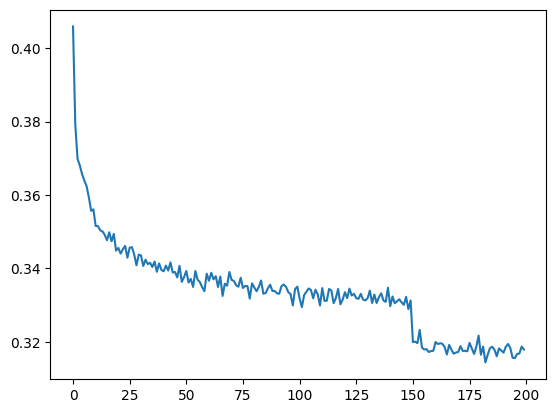

In [45]:
# Take average of loss over 1000 steps  - trick: reshape tensor then take mean over dim 1
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# Observe much smoother training loss curve
# There is a step decay probably due to the learning rate drop

In [34]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [35]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


In [28]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

zoevbsxzsqdfspfmsxnrgwdhisymoyeeoik.
zunsnqykfxqszzhotbfcstekpltoomdlptiqd.
msrqf.
yieywsk.
cmbxaodcveh.
qktw.
ildgagth.
bggkbrnuzxczvuvtmljbvlhhchthiepypuasomofgejsdlrkoddtitkkc.
unhnmpmixzfkturwcwdds.
.
adsjiabsvpyrqwbagxjr.
btuvmnotchwma.
dmtz.
wwpjvln.
uhllzndmbvlzpaaabkpvtrhseskeujffqubitvoupgujoyshgd.
.
bbswvfjwdfybqiywqykludrtgyajlwcmheowfzvxfvg.
frieyqtftrrxl.
umgtthrjjjunmnfksexehbztvagnwevamk.
ztapjxssfwcqvrpdloqepmptrooqtvkunwcrr.


In [ ]:
# Part 3: Code from above with WaveNet


In [ ]:
# Understand parallel processing of higher dimensional batches
# - assume example with 8 characters input block size
ix = torch. randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print (Xb. shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 14,  1, 20,  8],
        [ 0,  0, 13,  1,  4,  9, 19, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  1, 21]])

In [54]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([4, 8, 10])

In [55]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [56]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [ ]:
# Simulate process in linear layer
# Input of batch of 4 ex, with 8 characters and 10 dimensional embedding
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [59]:
# Also possible to process higher dimensional batch, linear layer simply broadcasted (or shared across instances)
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [ ]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

In [ ]:
# Especially relevant for groups of characters: (1 2) (3 4) (5 6) (7 8)
# Here batches would become something like: batch of 4 ex, with four subbatches of 4 character groups and 10 dimensional embedding (linear layer reused)
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

# Takeaways: Change flatten layer to output (4, 4, 20) instead of (4, 80) and change linear layer to 20 input dimensions

torch.Size([4, 4, 200])

In [ ]:
# First try to implement this new flatten layer
e = torch.rand(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
# Currently done
e.view(4, -1).shape # (4, 80)
# Concat even and odd parts for (1 2) (3 4) (5 6) (7 8)
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape # (4, 4, 20)
# Simpler and more efficient
e.view(4, 4, 20) # also works here due to arrangement of the inputs

torch.Size([4, 4, 20])

In [76]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [77]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()]) # type: ignore

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# Only add new layers here
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n
  
  def __call__(self, x):
    # Make explicit to simplify
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) # ensure that n characters / inputs are grouped into an embedding
    # If no grouping use, i.e. second dimension 1, squeeze it
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
# Fixed version for multiple dimensions
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      # Determine mean and variance over all batch dimensions
      dims = tuple(range(x.ndim - 1))
      xmean = x.mean(dims, keepdim=True) # batch mean
      xvar = x.var(dims, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


In [113]:
torch.manual_seed(42); # seed rng for reproducibility

In [114]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP
n_cons = 2 # the number of characters to combine

# Corresponds to Figure 3 in https://arxiv.org/pdf/1609.03499 (with one less hidden layer using 16 input characters)
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(n_cons),
  Linear(n_embd * n_cons, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_cons),
  Linear(n_hidden * n_cons, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_cons),
  Linear(n_hidden * n_cons, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [115]:
# Lets debug for some input
ix = torch.randint (0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
print (Xb.shape)
logits = model(Xb)

# Xb
for layer in model. layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

torch.Size([4, 8])


TypeError: mean() received an invalid combination of arguments - got (range, keepdim=bool), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: keepdim
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [110]:
fl = FlattenConsecutive(n_cons)
fl(torch.randn(4, 4, 200)).shape

torch.Size([4, 2, 400])

In [111]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.2824
  10000/ 200000: 2.0426
  20000/ 200000: 1.9114
  30000/ 200000: 2.2687
  40000/ 200000: 2.2697
  50000/ 200000: 1.7491
  60000/ 200000: 2.2745
  70000/ 200000: 1.9558
  80000/ 200000: 1.9214
  90000/ 200000: 2.0890
 100000/ 200000: 1.8990
 110000/ 200000: 2.0510
 120000/ 200000: 2.2194
 130000/ 200000: 1.9276
 140000/ 200000: 1.8325
 150000/ 200000: 2.0659
 160000/ 200000: 2.1112
 170000/ 200000: 1.8990
 180000/ 200000: 1.3996
 190000/ 200000: 2.2061


### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space